/tmp/ipykernel_19531/1347265741.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['A'].notna(), 'campaign'] = 'A'


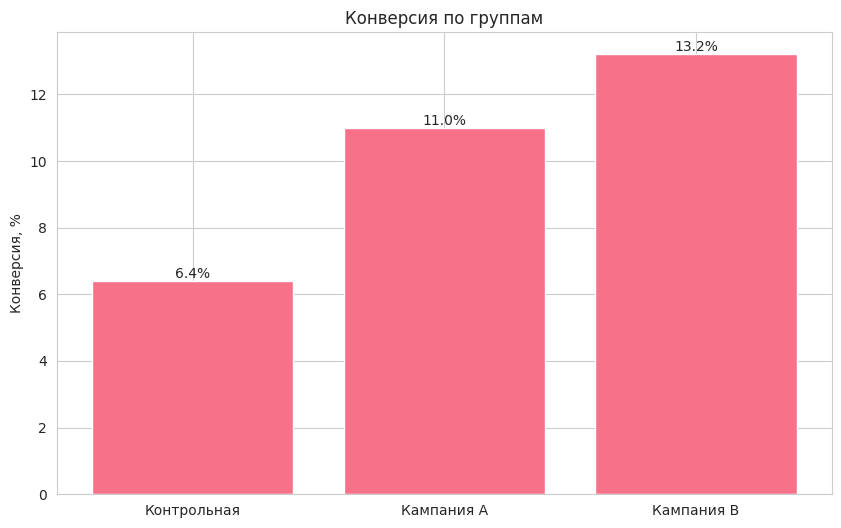

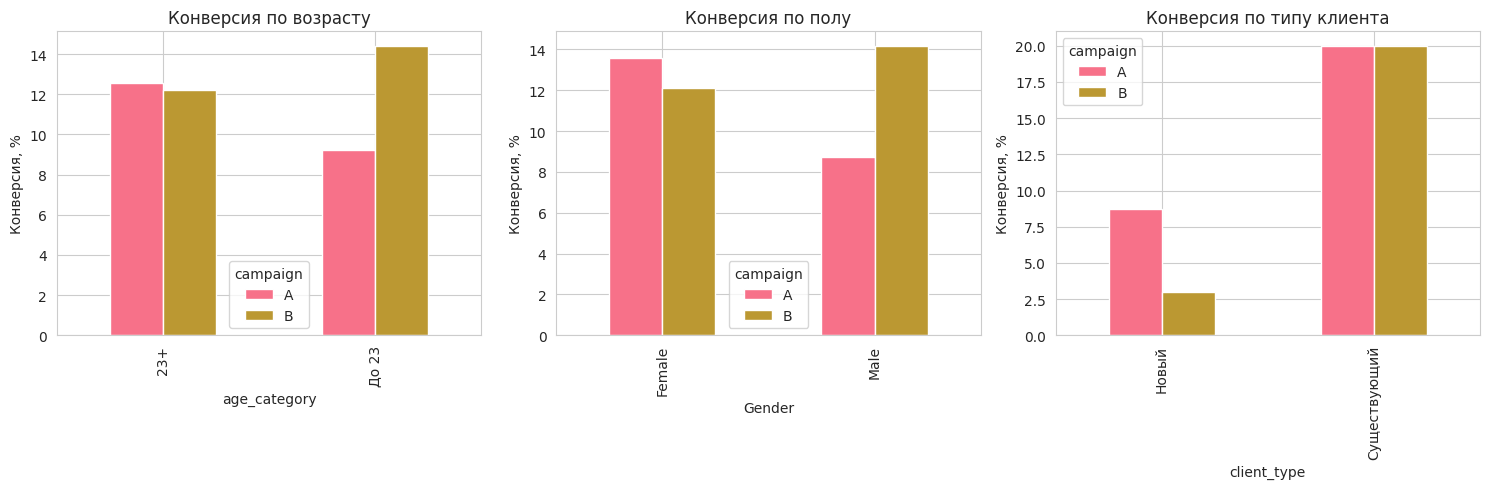

=== Общие результаты ===

Всего клиентов: 20,000
Клиентов в кампании A: 300
Клиентов в кампании B: 500
Клиентов в контрольной группе: 19,200

=== Конверсия ===
Общая: 6.64%
Кампания A: 11.00%
Кампания B: 13.20%
Контрольная группа: 6.40%

=== Прибыльность кампаний ===
Прогнозируемая прибыль кампании A: 1,116,000 руб.
Прогнозируемая прибыль кампании B: 2,383,200 руб.

=== Итоговые рекомендации ===
- Кампания B более прибыльна на 1,267,200 руб.
- Использовать кампанию A для возрастной группы '23+'
- Использовать кампанию B для возрастной группы 'До 23'
- Использовать кампанию A для пола 'Female'
- Использовать кампанию B для пола 'Male'
- Использовать кампанию A для типа клиента 'Новый'
- Использовать кампанию B для типа клиента 'Существующий'

=== Статистическая значимость ===
A vs Контроль: p-value = 1.0000
B vs Контроль: p-value = 1.0000
A vs B: p-value = 0.4214


In [9]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Настройка отображения русских символов
sns.set_style("whitegrid")
sns.set_palette("husl")
# df = pd.DataFrame(data)  # раскомментировать для тестирования
# Загрузка реальных данных
df = pd.read_csv('https://raw.githubusercontent.com/zalig/cu-datasets/main/advertisment.csv')

# Преобразование данных
def prepare_data(df):
    """Подготовка данных для анализа"""
    # Создаем колонку с типом кампании
    df['campaign'] = np.nan
    df.loc[df['A'].notna(), 'campaign'] = 'A'
    df.loc[df['B'].notna(), 'campaign'] = 'B'
    
    # Преобразуем Purchased в булевый тип
    df['purchased'] = df['Purchased'].notna()
    
    # Создаем категории возраста
    df['age_category'] = df['Age'].apply(lambda x: 'До 23' if x < 23 else '23+')
    
    # Определяем тип клиента
    current_year = 2024
    df['client_type'] = df['ClientSince'].apply(
        lambda x: 'Новый' if x == current_year else 'Существующий'
    )
    
    return df

df = prepare_data(df)

# Вспомогательные функции
def calculate_conversion(data, group_col=None):
    """Расчет конверсии для группы или всего датасета"""
    if group_col:
        return data.groupby(group_col)['purchased'].agg(['count', 'mean']).round(4)
    return data['purchased'].mean()

def test_significance(group1, group2, alpha=0.05):
    """Тест статистической значимости различий между группами"""
    contingency_table = pd.crosstab(
        pd.concat([group1, group2])['campaign'],
        pd.concat([group1, group2])['purchased']
    )
    result = stats.chi2_contingency(contingency_table)
    pvalue = result[1]
    return pvalue < alpha, pvalue

# Базовая статистика
total_clients = len(df)
group_a = df[df['campaign'] == 'A']
group_b = df[df['campaign'] == 'B']
control_group = df[df['campaign'].isna()]

# Расчет конверсий
conv_total = calculate_conversion(df)
conv_a = calculate_conversion(group_a)
conv_b = calculate_conversion(group_b)
conv_control = calculate_conversion(control_group)

# Экономические расчеты
PROFIT_PER_CUSTOMER = 3000  # Прибыль с одного клиента
AD_COST_PER_CUSTOMER = 80   # Стоимость рекламы на одного клиента
TARGET_PROFIT_INCREASE = 300000  # Целевое увеличение прибыли

def calculate_campaign_metrics(group_size, natural_conv, campaign_conv, cost_per_customer):
    """Расчет экономических метрик кампании"""
    additional_conv = campaign_conv - natural_conv
    additional_purchases = group_size * additional_conv
    revenue = additional_purchases * PROFIT_PER_CUSTOMER
    costs = group_size * cost_per_customer
    profit = revenue - costs
    return {
        'additional_purchases': additional_purchases,
        'revenue': revenue,
        'costs': costs,
        'profit': profit
    }

# Расчет метрик для обеих кампаний
metrics_a = calculate_campaign_metrics(
    len(control_group),
    conv_control,
    conv_a,
    AD_COST_PER_CUSTOMER
)

metrics_b = calculate_campaign_metrics(
    len(control_group),
    conv_control,
    conv_b,
    AD_COST_PER_CUSTOMER
)

# Анализ по демографическим группам
def analyze_demographics(data, segment_col):
    """Анализ конверсии по демографическим сегментам"""
    return pd.crosstab(
        data[segment_col],
        data['campaign'],
        values=data['purchased'],
        aggfunc='mean'
    ).round(4)

age_analysis = analyze_demographics(df, 'age_category')
gender_analysis = analyze_demographics(df, 'Gender')
client_type_analysis = analyze_demographics(df, 'client_type')

# Функции визуализации
def plot_conversion_rates():
    """Визуализация конверсий по группам"""
    conv_data = {
        'Контрольная': conv_control,
        'Кампания A': conv_a,
        'Кампания B': conv_b
    }
    plt.figure(figsize=(10, 6))
    plt.bar(conv_data.keys(), [v*100 for v in conv_data.values()])
    plt.title('Конверсия по группам')
    plt.ylabel('Конверсия, %')
    for i, v in enumerate(conv_data.values()):
        plt.text(i, v*100, f'{v*100:.1f}%', ha='center', va='bottom')
    plt.show()

def plot_demographic_analysis():
    """Визуализация анализа по демографическим группам"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Умножаем на 100 для отображения в процентах
    (age_analysis * 100).plot(kind='bar', ax=ax1, title='Конверсия по возрасту')
    (gender_analysis * 100).plot(kind='bar', ax=ax2, title='Конверсия по полу')
    (client_type_analysis * 100).plot(kind='bar', ax=ax3, title='Конверсия по типу клиента')
    
    ax1.set_ylabel('Конверсия, %')
    ax2.set_ylabel('Конверсия, %')
    ax3.set_ylabel('Конверсия, %')
    
    plt.tight_layout()
    plt.show()

# Выполнение визуализации
plot_conversion_rates()
plot_demographic_analysis()

# Статистические тесты
def run_full_statistical_analysis():
    """Проведение полного статистического анализа"""
    results = {}
    
    # A против контрольной группы
    a_vs_control = test_significance(
        group_a[['campaign', 'purchased']],
        control_group[['campaign', 'purchased']]
    )
    
    # B против контрольной группы
    b_vs_control = test_significance(
        group_b[['campaign', 'purchased']],
        control_group[['campaign', 'purchased']]
    )
    
    # A против B
    a_vs_b = test_significance(
        group_a[['campaign', 'purchased']],
        group_b[['campaign', 'purchased']]
    )
    
    return {
        'A_vs_Control': a_vs_control,
        'B_vs_Control': b_vs_control,
        'A_vs_B': a_vs_b
    }

statistical_results = run_full_statistical_analysis()

# Формирование рекомендаций
def generate_recommendations():
    """Генерация финальных рекомендаций"""
    recommendations = []
    
    # Сравнение общей прибыльности
    if metrics_a['profit'] > metrics_b['profit']:
        better_campaign = 'A'
        profit_difference = metrics_a['profit'] - metrics_b['profit']
    else:
        better_campaign = 'B'
        profit_difference = metrics_b['profit'] - metrics_a['profit']
    
    recommendations.append(f"Кампания {better_campaign} более прибыльна на {profit_difference:,.0f} руб.")
    
    # Рекомендации по демографическим группам
    segment_names = {
        'age_category': 'возрастной группы',
        'Gender': 'пола',
        'client_type': 'типа клиента'
    }
    
    for segment, segment_name in segment_names.items():
        segment_analysis = analyze_demographics(df, segment)
        for group in segment_analysis.index:
            if segment_analysis.loc[group, 'A'] > segment_analysis.loc[group, 'B']:
                recommendations.append(f"Использовать кампанию A для {segment_name} '{group}'")
            else:
                recommendations.append(f"Использовать кампанию B для {segment_name} '{group}'")
    
    return recommendations

final_recommendations = generate_recommendations()

# Вывод результатов анализа
print("=== Общие результаты ===")
print(f"\nВсего клиентов: {total_clients:,}")
print(f"Клиентов в кампании A: {len(group_a):,}")
print(f"Клиентов в кампании B: {len(group_b):,}")
print(f"Клиентов в контрольной группе: {len(control_group):,}")

print("\n=== Конверсия ===")
print(f"Общая: {conv_total:.2%}")
print(f"Кампания A: {conv_a:.2%}")
print(f"Кампания B: {conv_b:.2%}")
print(f"Контрольная группа: {conv_control:.2%}")

print("\n=== Прибыльность кампаний ===")
print(f"Прогнозируемая прибыль кампании A: {metrics_a['profit']:,.0f} руб.")
print(f"Прогнозируемая прибыль кампании B: {metrics_b['profit']:,.0f} руб.")

print("\n=== Итоговые рекомендации ===")
for rec in final_recommendations:
    print(f"- {rec}")

print("\n=== Статистическая значимость ===")
print(f"A vs Контроль: p-value = {statistical_results['A_vs_Control'][1]:.4f}")
print(f"B vs Контроль: p-value = {statistical_results['B_vs_Control'][1]:.4f}")
print(f"A vs B: p-value = {statistical_results['A_vs_B'][1]:.4f}")

# PRESENTATION
https://docs.google.com/presentation/d/1ucED5x9WmO_IjE7g8WwneQgVnWudKeMgcwXg6w9bT3I/edit?usp=sharing